In [35]:
!pip install osmnx
!pip install pandas
!pip install folium
!pip install scikit-learn


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [36]:
import osmnx as ox
import pandas as pd
import folium
from sklearn.cluster import KMeans
from folium.plugins import HeatMap
from scipy.spatial import Voronoi
import numpy as np
import matplotlib.colors
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point
from shapely.ops import unary_union

/var/folders/vz/b1smgzt13_dbs5c1rbj4m3dh0000gn/T/ipykernel_26330/1775836647.py:15: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  bus_stops = ox.geometries_from_place(place_name, tags=tags_bus)


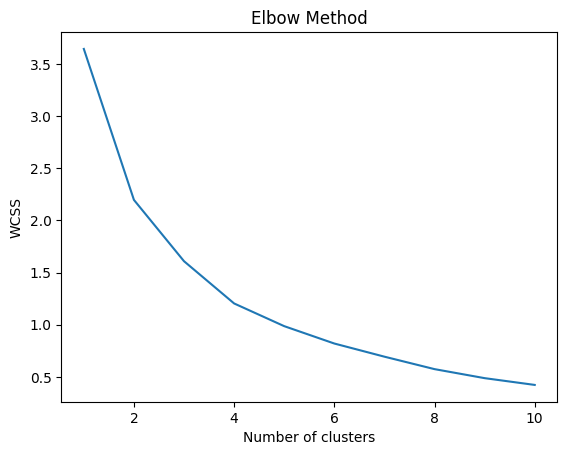

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [37]:
def is_bike_friendly(edge):
    bike_friendly_tags = ['yes', 'designated', 'permissive', 'lane', 'shared', 'shared_lane']
    bike_path_types = ['cycleway', 'path', 'living_street', 'residential']
    is_bike_tag_friendly = edge.get('bicycle') in bike_friendly_tags
    is_highway_type_friendly = edge.get('highway') in bike_path_types
    has_cycleway_infrastructure = ('cycleway' in edge) or ('cycleway:right' in edge) or ('cycleway:left' in edge)
    is_footway_bike_friendly = (edge.get('highway') in ['footway', 'pedestrian']) and edge.get('bicycle') == 'yes'
    return is_bike_tag_friendly or is_highway_type_friendly or has_cycleway_infrastructure or is_footway_bike_friendly

place_name = "Münster, Germany"
G = ox.graph_from_place(place_name, network_type='all')
df = pd.read_csv('filtered_data_munster.csv')

tags_bus = {'highway': 'bus_stop'}
bus_stops = ox.geometries_from_place(place_name, tags=tags_bus)

edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
bike_friendly_edges = edges[edges.apply(is_bike_friendly, axis=1)]

crs_proj = 'EPSG:32632'
bus_stops = bus_stops.to_crs(crs_proj)
bike_friendly_edges = bike_friendly_edges.to_crs(crs_proj)
nodes = ox.graph_to_gdfs(G, nodes=True, edges=False).to_crs(crs_proj)

bus_stops_buffer = bus_stops.buffer(20)
bike_friendly_buffer = bike_friendly_edges.buffer(20)

near_bus_stops = nodes[nodes.geometry.apply(lambda x: bus_stops_buffer.contains(x).any())]
near_bike_paths = nodes[nodes.geometry.apply(lambda x: bike_friendly_buffer.contains(x).any())]
near_both = near_bus_stops[near_bus_stops.index.isin(near_bike_paths.index)].to_crs('EPSG:4326')

df_near_both_coords = pd.DataFrame([(point.x, point.y) for point in near_both.geometry], columns=['Longitude', 'Latitude'])

# Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_near_both_coords[['Longitude', 'Latitude']])
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Select number of clusters based on Elbow Method
num_clusters = 1  # Set based on Elbow plot result

# K-Means Clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(df_near_both_coords[['Longitude', 'Latitude']])
near_both['Cluster'] = clusters

cluster_info = near_both.groupby('Cluster').agg({'geometry': 'count'}).rename(columns={'geometry': 'Count'})
max_count = cluster_info['Count'].max()
cluster_info['Normalized_Count'] = cluster_info['Count'] / max_count

map = folium.Map(location=[51.9625, 7.6256], zoom_start=13)

# Cluster visualization with interactive popups
for cluster_id, row in cluster_info.iterrows():
    cluster_center = kmeans.cluster_centers_[cluster_id]
    popup_text = f"Cluster: {cluster_id}\nCount: {row['Count']}"
    color = plt.cm.Reds(row['Normalized_Count'])
    color_hex = matplotlib.colors.to_hex(color)
    folium.Circle(
        location=[cluster_center[1], cluster_center[0]],
        radius=10 + row['Count'] * 2,
        color=color_hex,
        fill=True,
        fill_color=color_hex,
        fill_opacity=0.6,
        popup=popup_text
    ).add_to(map)

# Accident points visualization
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=3,
        color='blue',
        fill=True
    ).add_to(map)


# Save and display the map
map.save('kmeans_zones_munster.html')
map

In [38]:
!pip install geopy


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [39]:
from geopy.distance import geodesic

# Define the center and radius of the first cluster's circle
cluster_id = 0  # First cluster
cluster_center = kmeans.cluster_centers_[cluster_id]
radius = 10 + cluster_info.loc[cluster_id, 'Count'] * 2  # meters

# Function to check if a point is within the circle
def is_within_circle(point, center, radius):
    distance = geodesic((center[1], center[0]), (point.y, point.x)).meters
    return distance <= radius

# Filter near_both points for those within the first cluster's circle
first_cluster_circle_points = near_both[near_both.apply(lambda x: is_within_circle(x.geometry, cluster_center, radius), axis=1)]

# Clear previous points from the map if needed
map = folium.Map(location=[51.9625, 7.6256], zoom_start=13)

# Plot only those points within the first cluster's circle
for _, row in first_cluster_circle_points.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7
    ).add_to(map)

# Save and display the map
map.save('first_cluster_circle_points_only.html')
map


In [40]:
import folium
from sklearn.cluster import KMeans
import numpy as np
from shapely.geometry import Point
import geopandas as gpd

# Assuming new_points is a DataFrame with 'Latitude' and 'Longitude' columns
# new_points = pd.DataFrame(...) # Define your new_points DataFrame here

coordinates = first_cluster_circle_points[['geometry']].apply(lambda row: [row.geometry.x, row.geometry.y], axis=1).tolist()
coordinates_df = pd.DataFrame(coordinates, columns=['Longitude', 'Latitude'])

northernmost_point = coordinates_df['Latitude'].max()
southernmost_point = coordinates_df['Latitude'].min()
easternmost_point = coordinates_df['Longitude'].max()
westernmost_point = coordinates_df['Longitude'].min()

# Function to calculate the radius for each cluster
def calculate_cluster_radius(cluster_points):
    base_radius = 50  # Base radius for visibility
    number_of_points = len(cluster_points)
    radius = base_radius + np.sqrt(number_of_points) * 50  # Scaling factor
    return radius

# Initialize a new Folium map
map2 = folium.Map(location=[51.9625, 7.6256], zoom_start=13)

num_new_clusters = 8  # Adjust the number of new clusters as needed

# Perform new K-Means clustering on new_points
new_kmeans = KMeans(n_clusters=num_new_clusters, n_init=10, random_state=0)
new_clusters = new_kmeans.fit_predict(coordinates_df[['Longitude', 'Latitude']])
coordinates_df['Cluster'] = new_clusters

# Convert new_points to a GeoDataFrame
gdf = gpd.GeoDataFrame(coordinates_df, geometry=gpd.points_from_xy(coordinates_df.Longitude, coordinates_df.Latitude))

# Visualize the new clusters with red color and radius based on point count
for i in range(num_new_clusters):
    cluster_center_coords = new_kmeans.cluster_centers_[i]
    cluster_points = coordinates_df[coordinates_df['Cluster'] == i]
    new_cluster_radius = calculate_cluster_radius(cluster_points)

    folium.Circle(
        location=[cluster_center_coords[1], cluster_center_coords[0]],
        radius=new_cluster_radius,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(map2)

print(f"North Latitude: {northernmost_point}")
print(f"South Latitude: {southernmost_point}")
print(f"East Longitude: {easternmost_point}")
print(f"West Longitude: {westernmost_point}")

# Save and display the map
map2.save('enhanced_map_visualization.html')
map2


North Latitude: 51.9768825
South Latitude: 51.93187199999999
East Longitude: 7.6532245
West Longitude: 7.591165900000001


In [ ]:
# Define the bounding box using the extreme coordinate values
bounding_box = {
    'north': northernmost_point,
    'south': southernmost_point,
    'east': easternmost_point,
    'west': westernmost_point
}

bus_stops = bus_stops.to_crs('EPSG:4326')
bike_friendly_edges = bike_friendly_edges.to_crs('EPSG:4326')
nodes = nodes.to_crs('EPSG:4326')

# Function to check if a point is within the bounding box
def is_within_bounding_box(point, bounding_box):
    return (point.x >= bounding_box['west']) and (point.x <= bounding_box['east']) and (point.y >= bounding_box['south']) and (point.y <= bounding_box['north'])

# Convert bus_stops_within_bounds to WGS84 if it's not already
if bus_stops_within_bounds.crs != 'EPSG:4326':
    bus_stops_within_bounds = bus_stops_within_bounds.to_crs('EPSG:4326')


# Filter bus stops to include only those within the bounding box
bus_stops_within_bounds = bus_stops[bus_stops.geometry.apply(lambda x: is_within_bounding_box(x, bounding_box))]

# Filter bike-friendly edges to include only those within the bounding box
# Note: For line geometries, we're considering the centroid to determine if they're within the bounding box.
bike_friendly_edges_within_bounds = bike_friendly_edges[bike_friendly_edges.geometry.centroid.apply(lambda x: is_within_bounding_box(x, bounding_box))]

# ... continue with your existing code, using the filtered data
near_bus_stops = nodes[nodes.geometry.apply(lambda x: bus_stops_within_bounds.buffer(20).contains(x).any())]

# Find nodes near bike paths
near_bike_paths = nodes[nodes.geometry.apply(lambda x: bike_friendly_edges_within_bounds.buffer(20).contains(x).any())]

# Find nodes near both bus stops and bike paths
near_both = near_bus_stops[near_bus_stops.index.isin(near_bike_paths.index)].to_crs('EPSG:4326')

# You may want to adjust the dataframe creation based on your specific data structure
df_near_both_coords = pd.DataFrame([(point.x, point.y) for point in near_both.geometry], columns=['Longitude', 'Latitude'])


/var/folders/vz/b1smgzt13_dbs5c1rbj4m3dh0000gn/T/ipykernel_26330/4221067747.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bike_friendly_edges_within_bounds = bike_friendly_edges[bike_friendly_edges.geometry.centroid.apply(lambda x: is_within_bounding_box(x, bounding_box))]
/var/folders/vz/b1smgzt13_dbs5c1rbj4m3dh0000gn/T/ipykernel_26330/4221067747.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  near_bus_stops = nodes[nodes.geometry.apply(lambda x: bus_stops_within_bounds.buffer(20).contains(x).any())]
/var/folders/vz/b1smgzt13_dbs5c1rbj4m3dh0000gn/T/ipykernel_26330/4221067747.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to 

In [52]:
# Initialize a new Folium map centered around the middle of your bounding box
map_center_lat = (bounding_box['north'] + bounding_box['south']) / 2
map_center_lon = (bounding_box['east'] + bounding_box['west']) / 2
map = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=13)

# Add bus stops to the map with adjusted visualization
for _, row in bus_stops_within_bounds.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,  # Adjusted radius
        color='blue',  # Adjusted color
        fill=True,
        fill_color='blue',  # Adjusted fill color
        fill_opacity=0.9,  # Adjusted opacity
        popup='Bus Stop'
    ).add_to(map)

# Save and display the map
map.save('bus_stops_within_bounds.html')
map


In [54]:
# Initialize a new Folium map for bike-friendly edges
map_bike_edges = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=13)

# Plot bike-friendly edges
for _, row in bike_friendly_edges_within_bounds.iterrows():
    line_points = [(point[1], point[0]) for point in row.geometry.coords]
    folium.PolyLine(line_points, color='blue', weight=2, opacity=0.7).add_to(map_bike_edges)

# Save and display the map for bike-friendly edges
map_bike_edges.save('bike_friendly_edges_within_bounds.html')
map_bike_edges
